In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
from keras.datasets import mnist
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)
  return (X_train, y_train), (X_test, y_test)

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def preprocess_data(data):
  scaler = StandardScaler()
  data_std = scaler.fit_transform(data)
  n_components = 30
  pca = PCA(n_components=n_components)
  data_pca = pca.fit_transform(data_std)
  return data_pca

In [5]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [6]:
train_data_0 = pd.DataFrame(X_train[y_train == 0])
train_data_1 = pd.DataFrame(X_train[y_train == 1])[:3000]
train_data = pd.DataFrame(pd.concat([train_data_0,train_data_1]))
train = train_data.reset_index(drop = True)

train_label_0 = pd.DataFrame(y_train[y_train == 0])
train_label_1 = pd.DataFrame(y_train[y_train == 1])[:3000]
train_data_label = pd.DataFrame(pd.concat([train_label_0,train_label_1]))
y_train = train_data_label.reset_index(drop = True)

In [7]:
test_data_0 = pd.DataFrame(X_test[y_test.flatten() == 0])
test_data_1 = pd.DataFrame(X_test[y_test.flatten() == 1])[:500]
test_data = pd.DataFrame(pd.concat([test_data_0,test_data_1]))
test = test_data.reset_index(drop = True)

test_label_0 = pd.DataFrame(y_test[y_test == 0])
test_label_1 = pd.DataFrame(y_test[y_test == 1])[:500]
test_data_label = pd.DataFrame(pd.concat([test_label_0,test_label_1]))
y_test = test_data_label.reset_index(drop = True)

In [8]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [9]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

## **Expectation Step**

In [10]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_lbl(row,thetas):
  log_lbl = []
  for theta in thetas:
    alpha_K, alpha, beta, lamda = theta[:len(theta)-3], theta[len(theta)-3], theta[len(theta)-2], theta[len(theta)-1]
    c = gammaln(np.sum(alpha_K)) + gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta)
    q1 = (alpha-np.sum(alpha_K))*np.log(np.abs(1-np.mean(row))) + alpha*np.log(lamda)
    q2 = (alpha+beta)*np.log(np.abs(1-(1-lamda)*(1-np.mean(row)))) - (beta-1)*np.log(np.abs(np.mean(row)))
    q3 = np.sum(((alpha_K)-1)*np.log(row)) - np.sum(np.log(alpha_K))
    log_lbl.append(c+q1+q2+q3)
  return log_lbl

In [11]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def c_log_lbl(row,thetas):
  log_lbl = []
  for theta in thetas:
    alpha_K, alpha, beta, lamda = theta[:len(theta)-3], theta[len(theta)-3], theta[len(theta)-2], theta[len(theta)-1]
    q1 = (alpha-np.sum(alpha_K))*np.log(np.abs(1-np.mean(row)))
    q2 = (alpha+beta)*np.log(np.abs(1-(1-lamda)*(1-np.mean(row)))) - (beta-1)*np.log(np.abs(np.mean(row)))
    q3 = np.sum(((alpha_K)-1)*np.log(row))
    log_lbl.append(q1+q2+q3)
  return log_lbl

In [12]:
def expectation_step(data, thetas, P,number_of_clusters):
    Z = np.zeros((len(data), number_of_clusters))

    for i, row in enumerate(data):
        log_posteriors = np.log(P) + log_lbl(row, thetas)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        Z[i] = posteriors / np.sum(posteriors)
    return Z

## **Maximization Step** ##

In [13]:
def update_P(Z):
  return np.mean(Z,axis=0)

In [14]:
def normalize_theta(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [15]:
def calcul_inv_hess_vect(data,theta,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-15),None)
  inv_hess_vect_matrices = []
  for j in range(M):
    theta_j = theta[j]
    vect_alpha_j = theta_j[:len(theta_j)-3]
    S = np.diag([-1/(float(polygamma(1,vect_alpha_j[m]))*N*Z_mean[j]) for m in range(K)])
    a_T = np.array([[-1/(float(polygamma(1,vect_alpha_j[m]))*N*Z_mean[j]) for m in range(K)]])
    gamma_et = float(polygamma(1,np.sum(vect_alpha_j)))*N*Z_mean[j] / (1+float(polygamma(1,np.sum(vect_alpha_j)))*N*Z_mean[j]*np.sum([-1/(np.sum(vect_alpha_j)*N*Z_mean[j]) for m in range(K)]))
    H_inv = S + gamma_et*np.dot(a_T.T,a_T)
    inv_hess_vect_matrices.append(H_inv)
  return inv_hess_vect_matrices

In [16]:
def calcul_inv_hess_non_vect(data,theta,Z,number_of_clusters):
  M, N = number_of_clusters, data.shape[0]
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-6),None)
  inv_hess_non_vect_matrices = []
  for j in range(M):
    theta_j = theta[j]
    H_j = np.zeros((3,3))
    alpha_j, beta_j, lamda_j = theta_j[len(theta_j)-3], theta_j[len(theta_j)-2], theta_j[len(theta_j)-1]
    H_j[0][0] = N*Z_mean[j]*(float(polygamma(1,alpha_j+beta_j)) - float(polygamma(1,alpha_j)))
    H_j[1][1] = N*Z_mean[j]*(float(polygamma(1,alpha_j+beta_j)) - float(polygamma(1,beta_j)))
    H_j[2][2] = N*Z_mean[j]*((alpha_j+beta_j) / ((1-(1-lamda_j))**2) - (alpha_j/(lamda_j**2)))
    H_j[0][1] = H_j[1][0] = N*Z_mean[j]*float(polygamma(1,alpha_j+beta_j))
    H_j[0][2] = H_j[2][0] = N*Z_mean[j]*((1/lamda_j) - (1/(1-(1-lamda_j))))
    H_j[1][2] = H_j[2][1] = -N*Z_mean[j]*(1/(1-(1-lamda_j)))
    inv_H_j = np.linalg.inv(H_j)
    inv_hess_non_vect_matrices.append(inv_H_j)
  return inv_hess_non_vect_matrices

In [17]:
def derivative(data,theta_old,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.mean(Z,axis=0)
  der_param = []
  for j in range(M):
    der_vect_alpha_j = np.zeros(K)
    theta_old_j = theta_old[j]
    vect_alpha_old_j, alpha_old_j, beta_old_j, lamda_old_j = theta_old_j[:len(theta_old_j)-3], theta_old_j[len(theta_old_j)-3], theta_old_j[len(theta_old_j)-2], theta_old_j[len(theta_old_j)-1]
    for s in range(K):
      der_vect_alpha_j[s] =N*Z_mean[j]*(psi(np.sum(vect_alpha_old_j)) - psi(vect_alpha_old_j[s])) - np.sum( Z[:,j]*np.log(data[:,s]) )
    der_alpha_j = N*Z_mean[j]*(psi(alpha_old_j+beta_old_j)-psi(alpha_old_j) + np.log(np.clip(lamda_old_j,10**(-6),None))-np.log(np.clip(1-(1-lamda_old_j),10**(-6),None)))
    der_beta_j = N*Z_mean[j]*(psi(alpha_old_j+beta_old_j)-psi(beta_old_j)- np.log(np.clip(1-(1-lamda_old_j),10**(-8),None)))
    der_lamda_j = N*Z_mean[j]*((alpha_old_j/lamda_old_j) - (alpha_old_j+beta_old_j)/(1-(1-lamda_old_j)))
    der_theta_j = np.concatenate((der_vect_alpha_j, der_alpha_j,der_beta_j, der_lamda_j), axis=None)
    der_param.append(der_theta_j)
  return der_param

In [18]:
from keras.utils.generic_utils import to_list
def update_theta(data,theta_old,Z,number_of_clusters):
  M = number_of_clusters
  H_non_vect, H_vect = calcul_inv_hess_non_vect(data,theta_old,Z,number_of_clusters), calcul_inv_hess_vect(data,theta_old,Z,number_of_clusters)
  der_param = derivative(data,theta_old,Z,number_of_clusters)
  theta_new = []
  for j in range(M):
    (theta_old_j,der_param_j,H_non_vect_j,H_vect_j) = (theta_old[j],der_param[j],H_non_vect[j],H_vect[j])
    (vect_alpha_old_j, alpha_beta_lamda_old_j,der_vect_alpha_old_j, der_alpha_beta_lamda_old_j) = (theta_old_j[:len(theta_old_j)-3], theta_old_j[len(theta_old_j)-3:],der_param_j[:len(der_param_j)-3], der_param_j[len(der_param_j)-3:])
    vect_alpha_new_j = vect_alpha_old_j - np.dot(H_vect_j,der_vect_alpha_old_j)
    alpha_beta_lamda_new_j = alpha_beta_lamda_old_j - np.dot(H_non_vect_j,der_alpha_beta_lamda_old_j)
    theta_new.append(np.clip(normalize_theta(np.concatenate((vect_alpha_new_j,alpha_beta_lamda_new_j), axis=None),0.1,10),10**(-15),None))
  return theta_new

In [19]:
#We tried several random initializations, and these values gave us the best results
theta_zero =  [np.array([9.05411337, 5.75659936, 7.32690027, 5.56744322, 1.61018689,
       1.07028844, 3.03645226, 0.40477595, 0.12380822, 1.13113311,
       8.7420251 , 0.29875021, 9.6525017 , 0.62960678, 9.55303225,
       7.37774991, 0.65678556, 9.48550038, 3.35554359, 3.54472547,
       0.57675762, 5.99699231, 9.94905096, 3.72623275, 1.60962316,
       9.60350102, 8.74317445, 5.40894226, 3.78567748, 6.06539426,
       3.42419097, 4.23452954, 5.39597848]), np.array([0.7005937 , 2.5061026 , 2.04402278, 7.47863867, 3.55967681,
       8.21398249, 2.66421916, 3.31254912, 8.13906863, 2.85581301,
       6.35015731, 0.7455937 , 5.02479583, 2.24693879, 2.65130537,
       1.07291596, 5.30492351, 0.16767106, 8.63765323, 1.35242401,
       7.48136735, 7.23624053, 6.34091834, 1.84594568, 3.05263748,
       7.26723311, 4.50310715, 1.39606625, 1.51797579, 2.61567888,
       0.63803457, 9.42676709, 9.94274153])]

In [20]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

x_train_task = train
x_test_task = test

#EM Algorithm
M = 2
P = [0.15, 0.85]
theta_old = theta_zero
max_iter = 3
for iteration in range(max_iter):
  Z = expectation_step(x_train_task,theta_old,P,M)
  theta_new = update_theta(x_train_task,theta_old,Z,M)
  P = np.clip(update_P(Z),10**(-15),None)
  theta_old = theta_new

In [21]:
#Sometimes we need to switch the positions of the elements of the parameters vector to solve the label switching problem
theta_new = [theta_new[1],theta_new[0]]

In [22]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

predictions_bin = []
for row in x_test_task:
      log_posteriors = np.exp(np.log(P)+log_lbl(row,theta_new))
      predicted_label = np.argmin(log_posteriors)
      predictions_bin.append(predicted_label)
predictions_bin = np.asarray(predictions_bin)
labels = np.array(y_test).flatten() == 0
f1 = f1_score(labels, predictions_bin)
precision = precision_score(labels, predictions_bin)
recall = recall_score(labels, predictions_bin)
acc = accuracy_score(labels, predictions_bin)

print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", acc)

F1 score: 0.9410599306587419
Precision: 0.9143407122232916
Recall: 0.9693877551020408
Accuracy: 0.9195945945945946


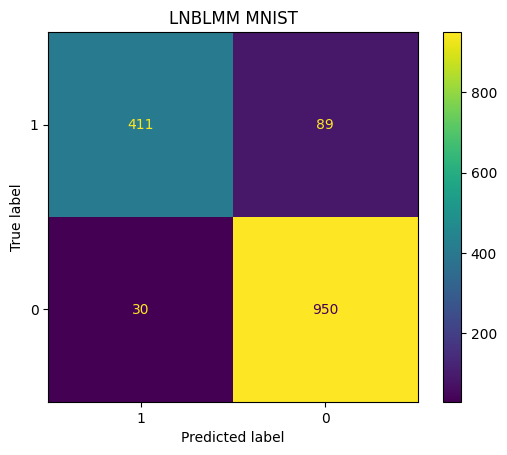

In [23]:
cm = confusion_matrix(labels, predictions_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1', '0'])
cm_display.plot()
cm_display.ax_.set_title('LNBLMM MNIST')
plt.show()